In [1]:
import time
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
from jax.config import config
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnl
config.update("jax_enable_x64", True)

<h1>TDSE Forward Problem</h1>

In [52]:
class fourier:

    def __init__(self, *args, seed=None):
        #####################################################
        # This method is called when the class object is
        # instantiated.
        # - args is a tuple containing the parameters needed
        #   to fully define the mode
        #####################################################

        # unpack the model parameters from args
        L, numx, numfour = args

        # store model parameters as class instance variables
        self._L = L
        self._numx = numx
        # this numfour is the number of Fourier basis used
        # to discretize the TDSE PDE
        self._numfour = numfour

        # create and initialize theta with random values
        # - theta is the model representation of the potential
        # - all model objects have the class method self.randtheta
        #   to generate a theta of random values, the result is
        #   stored as the instance variable self.theta
        self.theta = self.randtheta(self._L, self._numx, self._numfour, dist='uniform', seed=seed)


        #####################################################
        # The rest of this code is used for creating and
        # storing structures necessary for using the model
        #####################################################

        # vector of Fourier mode indices
        # fournvec = -numfour,...,0,...,numfour
        fournvec = np.arange(-numfour, numfour + 1)

        # real space grid points (for plotting)
        xvec = np.linspace(-L, L, numx)

        # matrix for converting Fourier representation to real space
        # used like realspacevec = fourspacevec @ fourtox
        self._fourtoxmat = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)

        self._numtoepelms = 2 * numfour + 1

        # Toeplitz indexing matrix, used for constructing
        # Toeplitz matrix from a vector which as been set up like:
        # jnp.concatenate([jnp.flipud(row.conj()), row[1:]])
        aa = (-1) * np.arange(0, self._numtoepelms).reshape(self._numtoepelms, 1)
        bb = [np.arange(self._numtoepelms - 1, 2 * self._numtoepelms - 1)]
        self._toepindxmat = np.array(aa + bb)


    def randtheta(*args, dist='uniform', seed=None):
        #####################################################
        # This method generates a model specific theta which
        # is filled with random values.
        # - args is a tuple containing the parameters needed
        #   to fully define the mode
        #####################################################

        # the last argument passed should always be numfour,
        # the rest can be ignored for this function
        numfour = args[-1]
        numtoepelms = 2 * numfour + 1

        if dist=='normal':
            theta = 0.001 * np.random.default_rng(seed).normal(size=numtoepelms * 2 - 1)  # mean=0, std=1, scale=0.001
        elif dist=='uniform':
            theta = 0.02 * np.random.default_rng(seed).random(size=2 * numtoepelms - 1) - 0.01  # interval=[-0.01, 0.01)
        else:
            print('Error fourier.init(): Distribution selection not recognized.')

        return theta


    def tox(self):
        ##################################################
        # This method transforms self.theta into a
        # real space potential
        ##################################################
        thetaR = self.theta[:self._numtoepelms]
        thetaI = jnp.concatenate((jnp.array([0.0]), self.theta[self._numtoepelms:]))
        thetacomplex = thetaR + 1j * thetaI

        potentialfourier = np.sqrt(2 * self._L) * np.concatenate([np.conjugate(np.flipud(thetacomplex[1:(self._numfour + 1)])), thetacomplex[:(self._numfour + 1)]])

        potentialxvec = jnp.real(potentialfourier @ self._fourtoxmat)

        return potentialxvec


    def tovmat(self):
        ##################################################
        # This method transforms self.theta into potential
        # operator matrix vmat in terms of w/e orthonormal
        # basis was used to discretize the TDSE
        # - Here we used the Fourier basis so theta is a
        #   vector containing the concatenation of the
        #   real and imaginary parts of vmat, its size
        #   should be:
        #   2 * numtoepelms - 1 = 4 * numfour + 1
        #################################################

        # to use theta we need to first recombine the real
        # and imaginary parts into a vector of complex values
        vtoephatR = self.theta[:self._numtoepelms]
        vtoephatI = jnp.concatenate((jnp.array([0.0]), self.theta[self._numtoepelms:]))
        vtoephat = vtoephatR + 1j * vtoephatI

        # construct vmathat from complex toeplitz vector
        vmathat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[self._toepindxmat]

        return vmathat


    def thetatovmat(theta, *args):
        #################################################
        # This method transforms theta (passed to the
        # method as an argument) into the potential
        # operator matrix vmat in terms of w/e orthonormal
        # basis was used to discretize the TDSE
        # - args is a tuple containing the parameters needed
        #   to fully define the mode
        # - theta is a vector containing the concatenation
        #   of the real and imaginary parts of vmat
        #   its size should be
        #   2 * numtoepelms - 1 = 4 * numfour + 1
        #################################################

        # unpack the model parameters from args
        L, numx, numfour = args
        numtoepelms = 2 * numfour + 1

        # Toeplitz indexing matrix, used for constructing
        # Toeplitz matrix from a vector which as been set up like:
        # jnp.concatenate([jnp.flipud(row.conj()), row[1:]])
        aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
        bb = [np.arange(numtoepelms - 1, 2 * numtoepelms - 1)]
        toepindxmat = np.array(aa + bb)

        # to use theta we need to first recombine the real
        # and imaginary parts into a vector of complex values
        vtoephatR = theta[:numtoepelms]
        vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
        vtoephat = vtoephatR + 1j * vtoephatI

        # construct vmathat from complex toeplitz vector
        vmathat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

        return vmathat


    def grad(self):
        ##################################################
        # This method computes \nabla_\theta H(\theta)
        # where H(\theta) = K + V(\theta)
        # Thus, this returns either the gradient of vmat
        # or the model representation of v(x) given
        # self.theta
        ##################################################

        # this code computes the real part of \nabla_\theta H(\theta)
        myeye = jnp.eye(self._numtoepelms)
        wsR = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
        ctrmatsR = wsR[self._toepindxmat]

        # this code computes the imaginary part of \nabla_\theta H(\theta)
        wsI = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:, 1:]])
        wsI = wsI[1:, :]
        wsI = wsI.T
        ctrmatsI = wsI[self._toepindxmat]

        # concatenate the real and imaginary parts of
        gradmat = jnp.concatenate([ctrmatsR, ctrmatsI], axis=2)

        return gradmat


    def thetatograd(theta, *args):
        ##################################################
        # This function computes \nabla_\theta H(\theta)
        # for a given theta without having access to
        # internal structures of the class
        # - args is a tuple containing the parameters needed
        #   to fully define the mode
        # - For the Fourier model, the gradient we need is
        #   \nabla_\theta vhatmat which is a constant so
        #   theta isn't used here
        ##################################################

        # unpack the model parameters from args
        L, numx, numfour = args
        numtoepelms = 2 * numfour + 1

        # Toeplitz indexing matrix, used for constructing
        # Toeplitz matrix from a vector which as been set up like:
        # jnp.concatenate([jnp.flipud(row.conj()), row[1:]])
        aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
        bb = [np.arange(numtoepelms - 1, 2 * numtoepelms - 1)]
        toepindxmat = np.array(aa + bb)

        # this code computes the real part of \nabla_\theta H(\theta)
        myeye = jnp.eye(numtoepelms)
        wsR = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
        ctrmatsR = wsR[toepindxmat]

        # this code computes the imaginary part of \nabla_\theta H(\theta)
        wsI = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:, 1:]])
        wsI = wsI[1:, :]
        wsI = wsI.T
        ctrmatsI = wsI[toepindxmat]

        # concatenate the real and imaginary parts of
        gradmat = jnp.concatenate([ctrmatsR, ctrmatsI], axis=2)

        return gradmat


    def fntomodel(fn, *args):
        #################################################
        # This method takes a function and returns the
        # model representation of it without using
        # structures internal to the class
        # - args is a tuple containing the parameters needed
        #   to fully define the mode
        #################################################

        # unpack the model parameters from args
        L, numx, numfour = args
        numtoepelms = 2 * numfour + 1

        # compute the potential operator matrix, vmat
        fntoep = []
        for thisfourn in range(numtoepelms):
            def intgrnd(x):
                return fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
            def rintgrnd(x):
                return intgrnd(x).real
            def iintgrnd(x):
                return intgrnd(x).imag
            fntoep.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

        fntoep = jnp.array(fntoep)

        return fntoep

    def fntotheta(fn, *args):
        #################################################
        # This method takes a function and returns
        # the theta
        # - theta is the structure given to the optimizer
        #   for learning and may be different from the
        #   model representation of a function (e.g.,
        #   the Fourier model represents a function as
        #   a set of complex valued coefficients, but we
        #   give the optimizer a concatenation of the real
        #   and imaginary parts of the model)
        # - args is a tuple containing the parameters needed
        #   to fully define the mode
        # This method takes a function and returns
        # the theta used by the Fourier class
        # - The Fourier model is the Toeplitz representation
        #   of vmat split into real and imaginary parts
        #   and concatenated together,
        #################################################
        fntoep = fourier.fntomodel(fn, *args)

        theta = jnp.concatenate((fntoep.real, fntoep[1:].imag))

        return theta

In [25]:
class cheby:

    def __init__(self, *args, seed=None):
        #####################################################
        # This method is called when the class object is
        # instantiated.
        # - args is a tuple containing the parameters needed
        #   to fully define the mode
        #####################################################
        L, numx, numfour, numcheb = args

        # store model parameters
        self._L = L
        self._numx = numx
        # this numfour is the number of Fourier basis used
        # to discretize the TDSE PDE
        self._numfour = numfour
        self._numcheb = numcheb

        self.theta = self.randtheta(self._L, self._numx, self._numfour, self._numcheb, dist='uniform', seed=seed)


        #####################################################
        # The rest of this code is used for creating and
        # storing structures necessary for using the model
        #####################################################

        # real space grid points (for plotting)
        xvec = np.linspace(-L, L, numx)

        chebnvec = np.arange(0, self._numcheb + 1)

        # matrix for transforming Chebyshev coefficients to
        # real space
        # used like: self._chebtox @ cheb_cff_vec
        self._chebtox = ss.eval_chebyt(np.expand_dims(chebnvec, 0), np.expand_dims(xvec / L, 1))

        # matrix for transforming the Chebyshev representation
        # to Fourier representation (this is used in the adjoint
        # method to construct vhatmat)
        chebtofourmat = []
        for thischebn in range(numcheb + 1):
            temptoeprow = []
            for thisfourn in range(2 * numfour + 1):
                def intgrnd(x):
                    return ss.eval_chebyt(thischebn, x / L) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
                def rintgrnd(x):
                    return intgrnd(x).real
                def iintgrnd(x):
                    return intgrnd(x).imag
                temptoeprow.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])
            chebtofourmat.append(sl.toeplitz(r=temptoeprow, c=np.conj(temptoeprow)))

        # used like: self._chebtofourmat @ cheb_cff_vec
        self._chebtofourmat = jnp.array(np.transpose(np.array(chebtofourmat), [1, 2, 0]))


    def randtheta(*args, dist='uniform', seed=None):
        #####################################################
        # This function generates a model specific theta which
        # is filled with random values.
        # - args is a tuple containing the parameters needed
        #   to fully define the mode
        #   - the last element in args should always be the number,
        #     of elements/shape of theta
        #####################################################

        # unpack shape of theta
        numcheb = args[-1]

        # the total number of Chebyshev coefficients = numcheb + 1
        if dist=='normal':
            theta = 0.001 * np.random.default_rng(seed).normal(size=numcheb + 1)  # mean=0, std=1
        elif dist=='uniform':
            theta = 10.0 * np.random.default_rng(seed).uniform(size=numcheb + 1) - 5.0  # mean=0, interval=[-5.0, 5.0)
        else:
            print('Error fourier.init(): Distribution selection not recognized.')

        return theta


    def tox(self):
        ##################################################
        # This method transforms self.theta into a
        # real space potential
        ##################################################

        return self._chebtox @ self.theta


    def tovmat(self):
        ##################################################
        # This method transforms self.theta into the
        # potential operator matrix vmat in terms of w/e
        # orthonormal basis was used to discretize the TDSE
        ##################################################

        vmathat = self._chebtofourmat @ self.theta
        return vmathat


    def thetatovmat(theta, *args):
        ##################################################
        # This method transforms theta (passed to the
        # method as an argument) into the potential
        # operator matrix vmat in terms of w/e orthonormal
        # basis was used to discretize the TDSE
        # - args is a tuple containing the parameters needed
        #   to fully define the mode
        ##################################################

        # unpack the model parameters from args
        L, numx, numfour, numcheb = args

        # matrix for transforming the Chebyshev representation
        # to Fourier representation (this is used in the adjoint
        # method to construct vhatmat)
        chebtofourmat = []
        for thischebn in range(numcheb + 1):
            temptoeprow = []
            for thisfourn in range(2 * numfour + 1):
                def intgrnd(x):
                    return ss.eval_chebyt(thischebn, x / L) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
                def rintgrnd(x):
                    return intgrnd(x).real
                def iintgrnd(x):
                    return intgrnd(x).imag
                temptoeprow.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])
            chebtofourmat.append(sl.toeplitz(r=temptoeprow, c=np.conj(temptoeprow)))

        # used like: chebtofourmat @ cheb_cff_vec
        chebtofourmat = jnp.array(np.transpose(np.array(chebtofourmat), [1, 2, 0]))

        vmathat = chebtofourmat @ theta

        return vmathat


    def grad(self):
        ##################################################
        # This method computes \nabla_\theta H(\theta)
        # where H(\theta) = K + V(\theta)
        # Thus, this returns either the gradient of vmat
        # or the model representation of v(x) given
        # self.theta
        ##################################################

        gradmat = self._chebtofourmat

        return gradmat


    def thetatograd(_, *args):
        ##################################################
        # This function computes \nabla_\theta H(\theta)
        # for a given theta without using the structures
        # internal to the class
        # - args is a tuple containing the parameters needed
        #   to fully define the mode
        ##################################################

        # unpack the model parameters from args
        L, numx, numfour, numcheb = args

        # matrix for transforming the Chebyshev representation
        # to Fourier representation (this is used in the adjoint
        # method to construct vhatmat)
        chebtofourmat = []
        for thischebn in range(numcheb + 1):
            temptoeprow = []
            for thisfourn in range(2 * numfour + 1):
                def intgrnd(x):
                    return ss.eval_chebyt(thischebn, x / L) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
                def rintgrnd(x):
                    return intgrnd(x).real
                def iintgrnd(x):
                    return intgrnd(x).imag
                temptoeprow.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])
            chebtofourmat.append(sl.toeplitz(r=temptoeprow, c=np.conj(temptoeprow)))

        # used like: gradmat @ cheb_cff_vec
        gradmat = jnp.array(np.transpose(np.array(chebtofourmat), [1, 2, 0]))

        return gradmat


    def fntomodel(fn, *args):
        #################################################
        # This method takes a function and returns
        # the theta
        # - theta is the structure given to the optimizer
        #   for learning and may be different from the
        #   model representation of a function (e.g.,
        #   the Fourier model represents a function as
        #   a set of complex valued coefficients, but we
        #   give the optimizer a concatenation of the real
        #   and imaginary parts of the model)
        # - args is a tuple containing the parameters needed
        #   to fully define the mode
        #################################################

        # unpack the model parameters from args
        L, numx, numfour, numcheb = args

        kvec = np.arange(1, numcheb + 2)
        chebnvec = np.arange(0, numcheb + 1)

        chebweights = np.ones(numcheb + 1)
        chebweights[0] = 0.5

        def chebtheta(k):
            return (k - 0.5) * np.pi / (numcheb + 1)

        def g(k):
            return fn(L * np.cos(chebtheta(k)))

        chebvec = 2 * np.sum(g(kvec) * np.cos(chebnvec[..., np.newaxis] * chebtheta(kvec)), axis=1) / (numcheb + 1)

        chebvec = chebweights * chebvec

        return chebvec


    # alias fntotheta to fntocheby because they are the same thing
    fntotheta = fntomodel


In [5]:
###############################################################
# set computational parameters
###############################################################

# size of spatial domain
L = 15.0

# number of real space grid points (for plotting)
numx = 1025

# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# number of Fourier basis functions
numfour = 32  # 64

# number of Toeplitz elements in the Fourier representation
numtoepelms = 2 * numfour + 1

# set number of time steps
# trajectory's length = numts + 1
numts = 20  # 20

# set time-step size
dt = 1e-2  # 1e-2

# print computational environment variables to stdout
print('L =', L)
print('numx =', numx)
print('numfour =', numfour)
print('numts =', numts)
print('dt =', dt)

L = 15.0
numx = 1025
numfour = 32
numts = 20
dt = 0.01


In [6]:
###############################################################
# utilities
###############################################################

# vector of Fourier mode indices
# fournvec = -numfour,...,0,...,numfour
fournvec = np.arange(-numfour, numfour + 1)

# matrix for converting Fourier representation to real space
# used like realspacevec = fourspacevec @ fourtox
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)

In [7]:
###############################################################
# Set trim of real space region
###############################################################

trim = np.where(xvec >= -10)[0][0]  # 125
print('trim =', trim)
print('')  # blank line

trim = 171



In [8]:
# ###############################################################
# # Toeplitz indexing matrix
# ###############################################################
#
# # Toeplitz indexing matrix, used for constructing Toeplitz matrix
# # from a vector setup like:
# # jnp.concatenate([jnp.flipud(row.conj()), row[1:]])
# aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
# bb = [np.arange(numtoepelms - 1, 2 * numtoepelms - 1)]
# toepindxmat = np.array(aa + bb)
# # print(toepindxmat.shape)

In [9]:
# ###############################################################
# # function for transforming theta to a real space potential
# ###############################################################
#
# def thetatoreal(theta):
#     ##################################################
#     # this function is used to transform theta, which
#     # is the Toeplitz representation of vmat that has
#     # also been split into real and imaginary parts
#     # and concatenated together, into a real space
#     # potential
#     ##################################################
#     thetaR = theta[:numtoepelms]
#     thetaI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
#     thetacomplex = thetaR + 1j * thetaI
#     potentialfourier = np.sqrt(2 * L) * np.concatenate([np.conjugate(np.flipud(thetacomplex[1:(numfour + 1)])), thetacomplex[:(numfour + 1)]])
#     potentialreal = potentialfourier @ fourtox
#     return potentialreal

---
**Potential Function**

In [10]:
# define potential for generating training data

def v(z):
    # harmonic oscillator potential (should be exact for Chebyshev)
    return 0.5 * z**2

    # symmetric double well potential
    # return 2.5e-3 * (z ** 2 - 25) ** 2

    # asymmetric double well potential
    # c0 = 4.35
    # c1 = 9.40e-1
    # c2 = -3.56e-1
    # c3 = -4.66e-2
    # c4 = 1.46e-2
    # c5 = 6.76e-4
    # c6 = -1.26e-4
    # c7 = -5.43e-6
    # c8 = 4.12e-7
    # c9 = 1.65e-8
    # x = z + 0.8
    # return 0.5 * (c0 + c1 * x + c2 * x ** 2 + c3 * x ** 3 + c4 * x ** 4 + c5 * x ** 5 + c6 * x ** 6 + c7 * x ** 7 + c8 * x ** 8 + c9 * x ** 9)

    # soft coulomb potential
    # return -1 / np.sqrt(x**2 + 0.25)

# true potential on real space grid (for plotting)
vtruexvec = v(xvec)


In [54]:
###############################################################
# model of true potential
###############################################################

# this is for when the model is cheby
# I have found from experience odd numbers for
# numcheb work best
# model = cheby
# numcheb = 11
# modelprms = (L, numx, numfour, numcheb)

# this is for when the model is fourier
model = fourier
modelprms = (L, numx, numfour)

# create a model class object and save as thetatrue
thetatrue = model(*modelprms)

# load thetatrue with the true potential represented in
# terms of the model
thetatrue.theta = model.fntotheta(v, *modelprms)

print('Shape thetatrue:', thetatrue.theta.shape)

Shape thetatrue: (129,)


l2 error vtruexvecrec: 0.5079525437523776
l-inf error vtruexvecrec: 0.040670882387431107


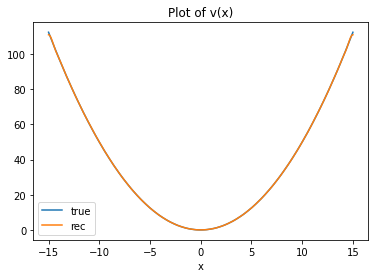

In [55]:
# thetatrue = jnp.concatenate((vtruetoep.real, vtruetoep[1:].imag))
# vtruemat = sl.toeplitz(r=vtruetoep, c=np.conj(vtruetoep))
# vtruexvecrec = thetatoreal(thetatrue)
# print('l2 error vtruexvecrec:', nl.norm(vtruexvecrec[trim:-trim] - vtruexvec[trim:-trim]))
# print('l-inf error vtruexvecrec:', np.amax(np.abs(vtruexvecrec[trim:-trim] - vtruexvec[trim:-trim])))

print('l2 error vtruexvecrec:', nl.norm(thetatrue.tox()[trim:-trim] - vtruexvec[trim:-trim]))
print('l-inf error vtruexvecrec:', np.amax(np.abs(thetatrue.tox()[trim:-trim] - vtruexvec[trim:-trim])))

# plot true potential
plt.plot(xvec, vtruexvec, label='true')
plt.plot(xvec, thetatrue.tox(), label='rec')
plt.title('Plot of v(x)')
plt.xlabel('x')
plt.legend()
plt.show()

---
**Initial States - a0**

Number of a0 states: 1


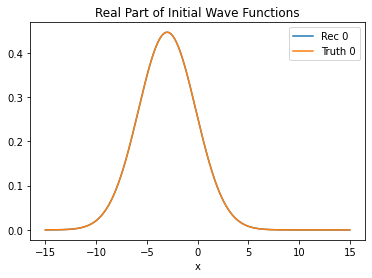

L2 Error of reconstructed psi0:
7.476210590807997e-05
L-infinity Error psi0:
3.137317008559103e-05


In [56]:
# define initial state functions
def psi0_0(x):
    return 10 * np.exp(-((x + 3) / 4)**2) * (2.0 / np.pi)**0.25
    # return 10 * np.exp(-((x + 3) / 2)**2) * (2.0 / np.pi)**0.25

def psi0_1(x):
    return np.exp(-((x - 3) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x - 3) / 2)**2) * (2.0 / np.pi)**0.25

def psi0_2(x):
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25
    return np.exp(-((x - 8) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x - 6)/4)**2) * (2.0 / np.pi)**0.25

def psi0_3(x):
    # a weird non-symmetric wavefunction
    # return np.abs(np.sin((0.15*x - 0.5)**2))
    return np.exp(-((x + 8) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x + 6)/4)**2) * (2.0 / np.pi)**0.25

def psi0_4(x):
    return np.exp(-((x - 12) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x - 11)**2) * (2.0 / np.pi)**0.25

def psi0_5(x):
    return np.exp(-((x + 12) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x + 11)**2) * (2.0 / np.pi)**0.25


# function for normalizing initial wave functions
# and transforming them to the Fourier representation
def mka0(psi0fn):
    # compute psi0 normalization term
    psi0fn_prob_intgrnd = lambda x: np.abs(psi0fn(x)) ** 2
    psi0fn_norm = np.sqrt(si.quad(psi0fn_prob_intgrnd, -L, L)[0])

    # normalized psi function (for integration)
    norm_psi0fn = lambda x: psi0fn(x) / psi0fn_norm

    # compute the Fourier representation of psi0fn
    a0raw = []
    for thisfourn in range (numfour + 1):
        def intgrnd(x):
            return norm_psi0fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        a0raw.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

    a0 = np.concatenate([np.conjugate(np.flipud(a0raw[1:])), a0raw])
    a0 = jnp.array(a0)
    normpsi0x = norm_psi0fn(xvec)

    return a0, normpsi0x


# generate initial state vector
# pick initial un-normalized wave functions
psi0fnvec = [psi0_0]  # [psi0_0, psi0_1, psi0_2, psi0_3]

# make initial states, a0, with mka0
a0vec = []
normpsi0xvec = []
normpsi0recxvec = []
for thispsi0fn in psi0fnvec:
    tempa0, tempnormpsi0x = mka0(thispsi0fn)
    a0vec.append(tempa0)
    normpsi0xvec.append(tempnormpsi0x)
    normpsi0recxvec.append(tempa0 @ fourtox)

a0vec = jnp.array(a0vec)
normpsi0xvec = np.array(normpsi0xvec)
normpsi0recxvec = np.array(normpsi0recxvec)

print('Number of a0 states:', a0vec.shape[0])

# plot the real part of the normalized psi0
for i in range(len(a0vec)):
    plt.plot(xvec, normpsi0recxvec[i].real, label=f'Rec {i}')
    plt.plot(xvec, normpsi0xvec[i].real, label=f'Truth {i}')
plt.title('Real Part of Initial Wave Functions')
plt.xlabel('x')
plt.legend()
plt.show()

print('L2 Error of reconstructed psi0:', nl.norm(normpsi0recxvec - normpsi0xvec), sep='\n')
print('L-infinity Error psi0:', np.max(np.abs(normpsi0recxvec - normpsi0xvec)), sep='\n')

---
<h3>Foward Propagation - Construct the Training Data</h3>

In [57]:
# make kinetic operator in the Fourier representation
# (this is constant for a given system)
kmat = np.diag(np.arange(-numfour, numfour + 1) ** 2 * np.pi ** 2 / (2 * L ** 2))
print('Shape kmat', kmat.shape)

# Hamiltonian operator with true potential
# in the Fourier representation
hmattrue = kmat + thetatrue.tovmat()
# hmattrue = kmat + vtruemat
print('Shape hmattrue', hmattrue.shape)

# eigen-decomposition of the Hamiltonian matrix
spctrue, stttrue = jnl.eigh(hmattrue)
print('Done with eigen-decomposition')

# compute propagator matrix
propatrue = stttrue @ jnp.diag(jnp.exp(-1j * spctrue * dt)) @ stttrue.conj().T
print('Shape propatrue', propatrue.shape)

# propagate system starting from initial "a" state
# using the Hamiltonian constructed from the true potential
# (used for generating training data)
amattruevec = []
for thisa0 in a0vec:
    tempamat = [thisa0.copy()]
    for _ in range(numts):
        tempamat.append(propatrue @ tempamat[-1])

    amattruevec.append(tempamat)

amattruevec = jnp.array(amattruevec)

print('Done propagating.')

Shape kmat (65, 65)
Shape hmattrue (65, 65)
Done with eigen-decomposition
Shape propatrue (65, 65)
Done propagating.


---
<h3>Inverse Problem - Adjoint Method</h3>

In [58]:
def waveobject(theta):
    #################################################
    # theta is the data structure given to the
    # optimizer which contains the potential in terms
    # of the model
    # - to use JAX, theta must be a JAX recognized
    #   object
    #################################################

    # #################################################
    # # theta is a vector containing the concatenation
    # # of the real and imaginary parts of vmat
    # # its size should be
    # # 2 * numtoepelms - 1 = 4 * numfour + 1
    # #################################################
    #
    # # to use theta we need to first recombine the real
    # # and imaginary parts into a vector of complex values
    # vtoephatR = theta[:numtoepelms]
    # vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
    # vtoephat = vtoephatR + 1j * vtoephatI
    #
    # # construct vmathat from complex toeplitz vector
    # vhatmat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

    # **************************************************
    # the following code enclosed by ' # ****' is the
    # same regardless of the model use
    # **************************************************
    # construct vmathat using the model class method
    # .tovmat(), theta is what ever the model class
    # uses as the data structure to store the potential
    # any other arguments are what is required to define
    # the model
    vhatmat = model.thetatovmat(theta, *modelprms)

    # Construct Hamiltonian matrix
    hhatmat = kmat + vhatmat

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hhatmat)

    # compute propagator matrix
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T

    # forward propagation loop
    ahatmatvec = []
    for r in range(a0vec.shape[0]):
        thisahatmat = [a0vec[r].copy()]

        # propagate system starting from initial "a" state
        for _ in range(numts):
            # propagate the system one time-step
            thisahatmat.append(propahat @ thisahatmat[-1])

        ahatmatvec.append(thisahatmat)

    # transform python list to a jax.numpy array
    ahatmatvec = jnp.array(ahatmatvec)

    # compute objective functions
    resid = ahatmatvec - amattruevec

    # as per our math, we need to take the real part of
    # the objective
    rtnobjvec = jnp.real(0.5 * jnp.sum(jnp.conj(resid) * resid, axis=1))
    rtnobj = jnp.sum(rtnobjvec)
    # **************************************************

    return rtnobj


# jit wavefnobject()
jitfourwaveobject = jax.jit(waveobject)

# precompile jitwavefnobject with Chebyshev representation
# of the true potential
# JAX can only deal with JAX, NumPy, Python or list type objects
# so to get around this, we are going to pass the data structure which
# stores the model's representation of the potential, i.e, theta
# print('jitchebwaveobject(thetatrue) =', fourwaveobject(thetatrue))
print('jitchebwaveobject(thetatrue.theta) =', jitfourwaveobject(thetatrue.theta))

jitchebwaveobject(thetatrue.theta) = 0.0


In [59]:
jitfourwaveobjectjax = jax.jit(jax.grad(waveobject))

# precompile chebwavegradsjax with Chebyshev representation
# of the true potential
print('nl.norm(jitchebwavegradsjax(vtruecheb)) =', nl.norm(jitfourwaveobjectjax(thetatrue.theta)))

nl.norm(jitchebwavegradsjax(vtruecheb)) = 0.0


---
**Adjoint Method**

In [60]:
###############################################################
# adjoint method for computing gradient
###############################################################

def wavegradsadj(theta):
    #################################################
    # theta is the data structure given to the
    # optimizer which contains the potential in terms
    # of the model
    # - to use JAX, theta must be a JAX recognized
    #   object
    #################################################

    # # to use theta we need to first recombine the real
    # # and imaginary parts into a vector of complex values
    # vtoephatR = theta[:numtoepelms]
    # vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
    # vtoephat = vtoephatR + 1j * vtoephatI
    #
    # # construct vmathat from complex toeplitz vector
    # vhatmat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

    # construct vmathat using the model class method
    # .tovmat(), theta is what ever the model class
    # uses as the data structure to store the potential
    # any other arguments are what is required to define
    # the model
    vhatmat = model.thetatovmat(theta, *modelprms)

    # **************************************************
    # the code enclosed by ' # ****' is the same regardless
    # of what model you use
    # **************************************************
    # Construct Hamiltonian matrix
    hhatmat = kmat + vhatmat

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hhatmat)

    # compute propagator matrices
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T
    proplam = jnp.transpose(jnp.conjugate(propahat))

    # forward propagation
    ahatmatvec = []
    lammatvec = []
    for r in range(a0vec.shape[0]):
        ####################################################
        # build ahatmat, i.e., forward propagate of the
        # system with theta starting from a given initial
        # state a0
        ####################################################

        # initialize thisahatmat with given a0 state
        thisahatmat = [a0vec[r].copy()]

        # forward propagate of the system with theta
        for i in range(numts):
            # propagate the system one time-step and store the result
            thisahatmat.append(propahat @ thisahatmat[-1])

        # store compute ahatmat
        ahatmatvec.append(jnp.array(thisahatmat))

        ####################################################
        # build lammat
        # \lambda_N = (\hat{a}_N - a_N)
        # \lambda_j = (\hat{a}_j - a_j) + [\nabla_a \phi_{\Delta t} (a_j; \theta)]^\dagger \lambda_{j+1}
        # [\nabla_a \phi_{\Delta t} (a_j; \theta)]^\dagger = [exp{-i H \Delta t}]^\dagger
        ####################################################

        # compute the error of ahatmatvec[r] WRT amattruevec[r]
        thisahatmaterr = ahatmatvec[r] - amattruevec[r]

        # initialize thislammat
        thislammat = [thisahatmaterr[-1]]

        # build lammat backwards then flip
        for i in range(2, numts + 2):
            thislammat.append(thisahatmaterr[-i] + proplam @ thislammat[-1])

        # flip thislammat, make into a jax array, and add to lammatvec
        lammatvec.append(jnp.flipud(jnp.array(thislammat)))

    # make lists into JAX array object
    ahatmatvec = jnp.array(ahatmatvec)
    lammatvec = jnp.array(lammatvec)
    # **************************************************


    ####################################################
    # the remainder of this function is for computing
    # the gradient of the exponential matrix
    # - The blocks of code surrounded by '# ***...'
    #   are common to the adjoint method when using
    #   the Fourier basis to discretize, regardless
    #   of the model
    ####################################################

    # **************************************************
    # the code enclosed by ' # ****' is the same regardless
    # of what model you use
    # - Given the diagonalization H = U D U^\dagger
    # - The final gradient \nabla_\theta \phi(a;\theta)
    #   is Q = U M U^\dagger, where M = A (*) mask
    #   and A = U^\dagger [\nabla_\theta H = \nabla_\theta model of vhatmat or v(x)] U
    # **************************************************
    offdiagmask = jnp.ones((numtoepelms, numtoepelms)) - jnp.eye(numtoepelms)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelms)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)

    # get the gradient of the model, function expects
    # model.thetatograd(theta, *args), where args is
    # what ever elements the model needs to be fully defined
    modelgrad = model.thetatograd(theta, *modelprms)

    # this line computes U^\dagger \nabla_\theta H(\theta) U
    prederivamat = jnp.einsum('ij,jkm,kl->ilm', stthat.conj().T, modelgrad, stthat)

    # this line computes
    # M_{i l} = A_{i l} (exp(D_{i i}) or (exp(D_{i i}) - exp(D_{l l}))/(D_{i i} - D_{l l}))
    derivamat = prederivamat * jnp.expand_dims(mask, 2)

    # this line computes Q = U M U^\dagger
    alldmat = -1j * dt * jnp.einsum('ij,jkm,kl->mil', stthat, derivamat, stthat.conj().T)

    # compute all entries of the gradient at once
    gradients = jnp.real(jnp.einsum('bij,ajk,bik->a', jnp.conj(lammatvec[:, 1:]), alldmat, ahatmatvec[:, :-1]))
    # **************************************************

    return gradients


# jist adjgrads
jitfourwavegradsadj = jax.jit(wavegradsadj)

# precompile chebwavegradsjax with Chebyshev representation
# of the true potential
print('nl.norm(jitchebwavegradsadj(vtruecheb)) =', nl.norm(jitfourwavegradsadj(thetatrue.theta)))

nl.norm(jitchebwavegradsadj(vtruecheb)) = 4.0690680447589486e-15


In [63]:
###############################################################
# Evaluate adjoint gradient
# - generate a theta of random values
# - compute the adjoint and JAX gradients
# - compute the error of the adjoint gradient WRT the JAX
#   gradient
###############################################################

# number of iterations
numitr = 10

# evaluate the gradients
totalerr = 0
for i in range(numitr):
    # generate a theta with random values
    thisthetarnd = model.randtheta(*modelprms)

    # compute the gradient
    t1 = time.time()
    adjgrad = jitfourwavegradsadj(thisthetarnd)
    t2 = time.time()
    jaxgrad = jitfourwaveobjectjax(thisthetarnd)
    t3 = time.time()

    # results
    print("adj time =", t2 - t1)
    print("jax time =", t3 - t2)
    thiserr = nl.norm(adjgrad - jaxgrad)
    totalerr += thiserr
    print("error =", thiserr)

print('Mean error:', totalerr/numitr)

adj time = 0.010131120681762695
jax time = 0.011352777481079102
error = 2.155137746828612e-12
adj time = 0.0028243064880371094
jax time = 0.011209249496459961
error = 1.2179526834319964e-12
adj time = 0.0027878284454345703
jax time = 0.011241436004638672
error = 4.528288640886508e-12
adj time = 0.002800464630126953
jax time = 0.010670900344848633
error = 5.693687794560229e-12
adj time = 0.002877950668334961
jax time = 0.010622739791870117
error = 4.0415847806244495e-12
adj time = 0.0034742355346679688
jax time = 0.010604143142700195
error = 3.141297907872571e-12
adj time = 0.0034742355346679688
jax time = 0.010634660720825195
error = 3.1767991391679365e-12
adj time = 0.0027878284454345703
jax time = 0.011336088180541992
error = 4.872336932797938e-12
adj time = 0.002808809280395508
jax time = 0.011404275894165039
error = 6.897093360002245e-12
adj time = 0.0027954578399658203
jax time = 0.011414051055908203
error = 3.664935573706786e-12
Mean error: 3.938911455987927e-12


---

In [64]:
# set seed to to None for random initialization
thetalearn = model(*modelprms, seed=1234)
print(thetalearn.theta.shape)

(129,)


In [65]:
thetalearn.theta = so.minimize(fun=jitfourwaveobject, x0=thetalearn.theta, jac=jitfourwavegradsadj, tol=1e-12, options={'maxiter': 4000, 'disp': True, 'gtol': 1e-15}).x

         Current function value: 0.000000
         Iterations: 1620
         Function evaluations: 1760
         Gradient evaluations: 1750


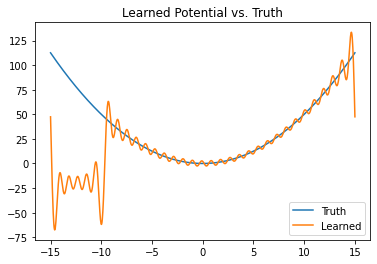

l2 norm of thetalearn: 1419.0752253569287
l-inf norm of thetalearn 173.97258709901445

l2 norm of trimmed thetalearn: 335.4191247643805
l-inf norm of trimmed thetalearn 111.89031500911331


In [66]:
# plot learned vs true
plt.plot(xvec, vtruexvec, label='Truth')
# plt.plot(xvec, thetatoreal(thetarnd), label='Initial')
plt.plot(xvec, thetalearn.tox(), label='Learned')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

print('l2 norm of thetalearn:', nl.norm(vtruexvec - thetalearn.tox()))
print('l-inf norm of thetalearn', np.amax(np.abs(vtruexvec - thetalearn.tox())))
print('')  # blank line

print('l2 norm of trimmed thetalearn:', nl.norm(vtruexvec[trim:-trim] - thetalearn.tox()[trim:-trim]))
print('l-inf norm of trimmed thetalearn', np.amax(np.abs(vtruexvec[trim:-trim] - thetalearn.tox()[trim:-trim])))